In [7]:
import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parse_results import *
from utils.utils import *
from db_utils.utils import *
from db_utils.query_storage import *
import networkx as nx
from cardinality_estimation.algs import *
import numpy as np
from cardinality_estimation.losses import *
#from cardinality_estimation.join_loss import JoinLoss, get_join_cost_sql, get_leading_hint
from cardinality_estimation.join_loss import *
from cardinality_estimation.nn import update_samples

from sql_rep.utils import nodes_to_sql, path_to_join_order
import cvxpy as cp
import time
import copy
from multiprocessing import Pool
from scripts.analyze_query import QUAD_BETAS
# FIXME: separate jupyter utils files especially for plotting utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'sql_rep'

In [8]:
COST_MODEL = "cm1"
COST_KEY = COST_MODEL + "cost"


QUERY_DIR = "./debug_sqls/"
query = "2.pkl"

qfn = QUERY_DIR + query
postgres = Postgres()
true_alg = TrueCardinalities()

USER = "pari"
PWD = ""
HOST = "localhost"
PORT = 5432
DB_NAME = "imdb"
#SAVE_DIR = "./QueryLabPlots/"

SAVE_DIR ="./figures/analysis/"
make_dir(SAVE_DIR)
FN_TMP = SAVE_DIR + "Loss-Comparison-SingleSubset-{SUBSET}.png"
FN_TMP2 = SAVE_DIR + "FlowLoss-SingleSubset-{SUBSET}.png"

# for join loss computations

QUERY_ERRORS_DATA_FN = "all_subquery/" + query + "/query_data.pkl"

In [3]:
assert os.path.exists(QUERY_ERRORS_DATA_FN)
data = load_object(QUERY_ERRORS_DATA_FN)
subsets = list(data.keys())[0]
flow_plan_errs = list(zip(*data[str(subsets)][-2]))
print(flow_plan_errs[1])
print(set(flow_plan_errs[1]))
quad_errs = data[str(subsets)][-4]
#print(quad_errs)
flow_plans = list(zip(*data[str(subsets)][-1]))

# for k,v in data.items():
#     for i,err in enumerate(v):
#         print(i, len(err))

NameError: name 'os' is not defined

In [16]:
def plot_subset_fig(data, subsets, legend=False, plot_plan_err=False):
    xs,qerrs,flow_errs,plan_errs,pg_errs,_,_,_,_,_ = data[subsets]
    flow_errs = list(zip(*flow_errs))[1]
    flow_errs = np.round(flow_errs)

    subsets = subsets.replace("[","")
    subsets = subsets.replace("]","")
    
    plt.figure(figsize=(5,4))
    plt.style.use('ggplot')
    ax = plt.gca()
    
    if plot_plan_err:
        errors_list = [flow_errs, plan_errs]
        ax_list = [ax, ax.twinx()]
    else:
        errors_list = [qerrs, pg_errs, flow_errs]
        ax_list = [ax, ax.twinx(), ax.twinx()]

    colors = ["b", "r", "g", "violet"]
    #labels = ["Q-Error", "Postgres Error", "Plan Error", "Flow Error"]
    
    if plot_plan_err:
        labels = ["Flow Error", "Phi Plan Error"]
    else:
        labels = ["Q-Error", "Postgres Plan Error", "Flow Error"]

    HUES = {}
    HUES["Q-Error"] = "green"
    HUES["Flow Error"] = "blue"
    
    if plot_plan_err:
        HUES["Phi Plan Error"] = "magenta"
    else:
        HUES["Postgres Plan Error"] = "red"
    
    lines = []
    for i, error in enumerate(errors_list):
        cur_ax = ax_list[i]
        sns.lineplot(xs, error, label=labels[i], ax=cur_ax, linewidth=5.0, zorder=5, 
                     color=HUES[labels[i]])
        lines.append(cur_ax.get_lines()[0])
        #if i != 0:
        cur_ax.get_yaxis().set_visible(False)
        cur_ax.set_ylim(0, None)
        cur_ax.get_legend().set_visible(False)
            
    plt.xscale("log")
    #plt.ylabel("Errors")
    #ax.set_xlabel("Cardinality Estimate" of "+subsets")
    ax.set_xlabel("Cardinality Estimate")

    if legend:
        ax.legend(lines, [l.get_label() for l in lines], 
                  loc='lower left',
                bbox_to_anchor=(0.0,1.01), ncol=3, frameon=False, borderaxespad=0)
        
#         legend1 = ax.legend(title="Loss Function", loc="lower left", 
#                   bbox_to_anchor=(0.0, 1.01), ncol=1, frameon=False,
#                   borderaxespad=0)
    
    if plot_plan_err:
        fn = FN_TMP.format(SUBSET=subset + "-PlanError")
    else:
        fn = FN_TMP.format(SUBSET=subset)
    #plt.tight_layout()
    plt.savefig(fn, bbox_inches="tight")

[('t',)]
[('ci',)]
[('kt',)]
[('n',)]
[('rt',)]
[('ci', 't')]
[('kt', 't')]
[('ci', 'n')]
[('ci', 'rt')]
[('ci', 'kt', 't')]
[('ci', 'n', 't')]


<ipython-input-16-5a1a24992f3c>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))
<ipython-input-16-5a1a24992f3c>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))


[('ci', 'rt', 't')]


<ipython-input-16-5a1a24992f3c>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))
<ipython-input-16-5a1a24992f3c>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))


[('ci', 'n', 'rt')]


<ipython-input-16-5a1a24992f3c>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))
<ipython-input-16-5a1a24992f3c>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))


[('ci', 'kt', 'n', 't')]


<ipython-input-16-5a1a24992f3c>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))
<ipython-input-16-5a1a24992f3c>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))


[('ci', 'kt', 'rt', 't')]


<ipython-input-16-5a1a24992f3c>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))
<ipython-input-16-5a1a24992f3c>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))


[('ci', 'n', 'rt', 't')]


<ipython-input-16-5a1a24992f3c>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))
<ipython-input-16-5a1a24992f3c>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))


[('ci', 'kt', 'n', 'rt', 't')]


<ipython-input-16-5a1a24992f3c>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))
<ipython-input-16-5a1a24992f3c>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))


dict_keys(["[('t',)]", "[('ci',)]", "[('kt',)]", "[('n',)]", "[('rt',)]", "[('ci', 't')]", "[('kt', 't')]", "[('ci', 'n')]", "[('ci', 'rt')]", "[('ci', 'kt', 't')]", "[('ci', 'n', 't')]", "[('ci', 'rt', 't')]", "[('ci', 'n', 'rt')]", "[('ci', 'kt', 'n', 't')]", "[('ci', 'kt', 'rt', 't')]", "[('ci', 'n', 'rt', 't')]", "[('ci', 'kt', 'n', 'rt', 't')]"])


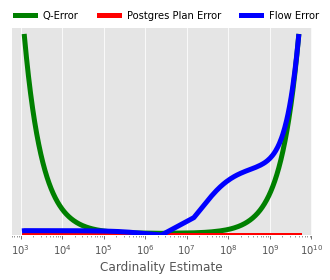

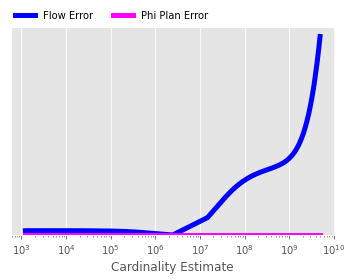

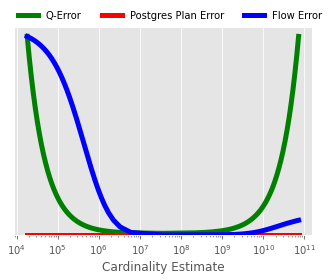

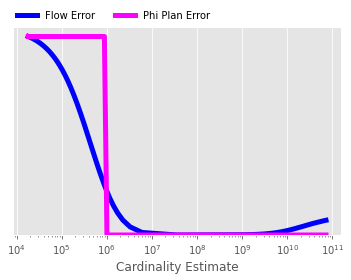

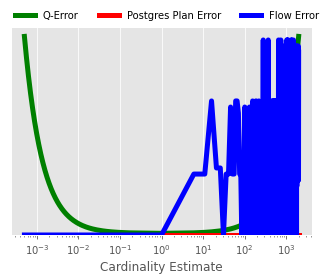

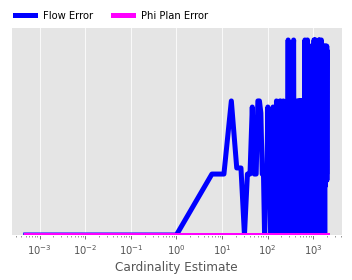

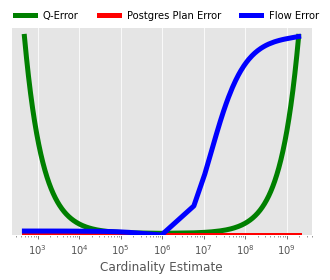

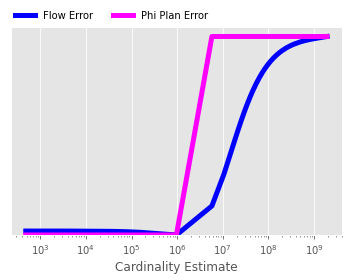

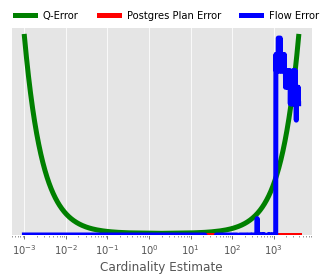

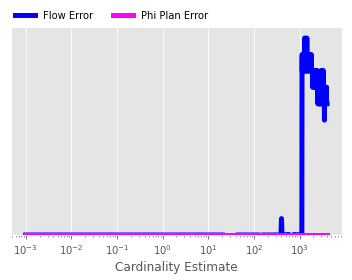

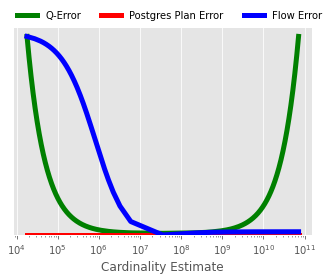

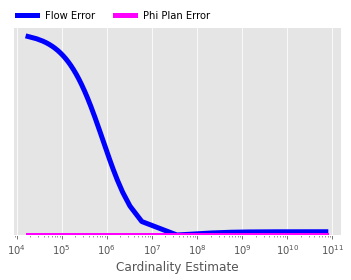

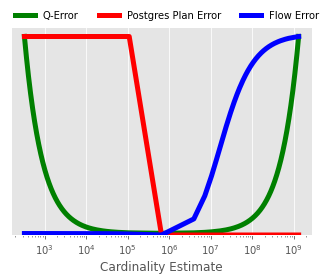

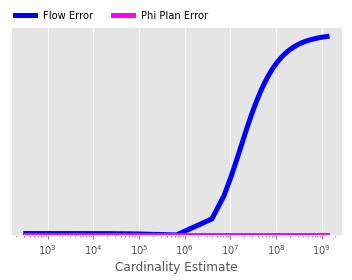

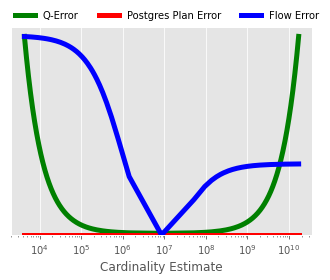

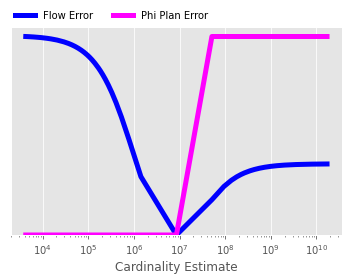

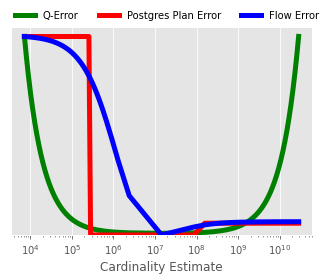

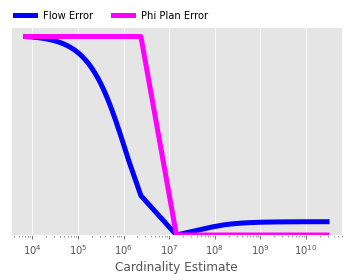

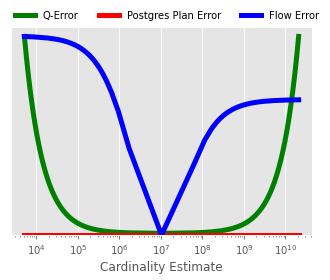

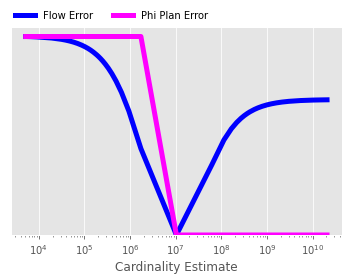

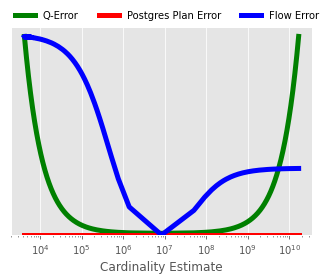

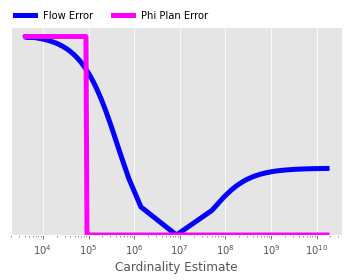

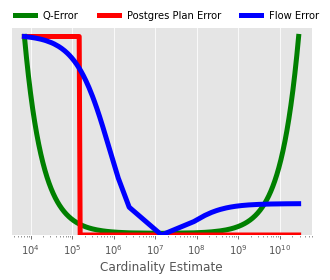

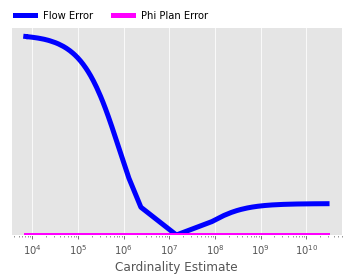

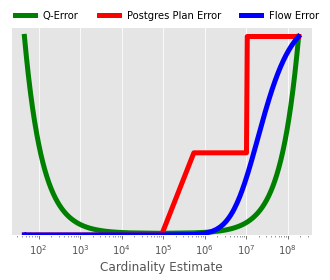

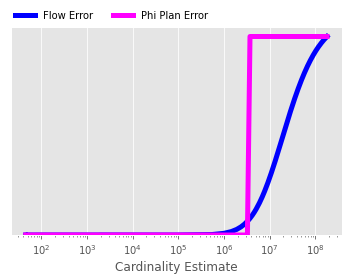

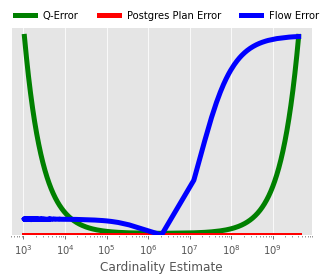

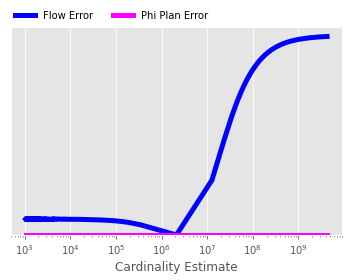

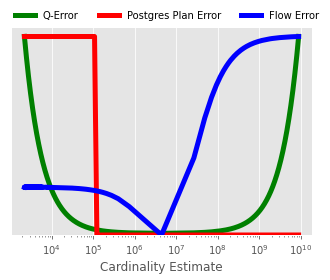

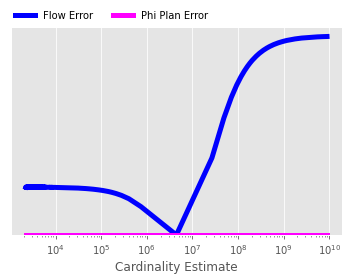

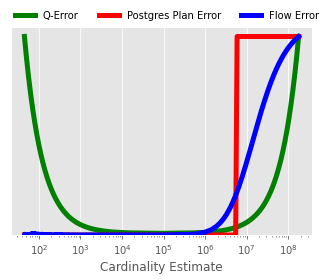

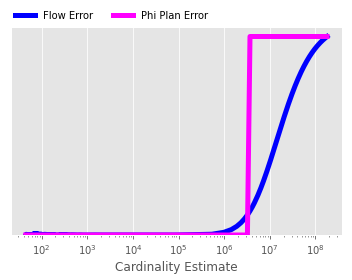

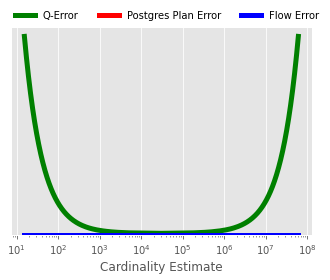

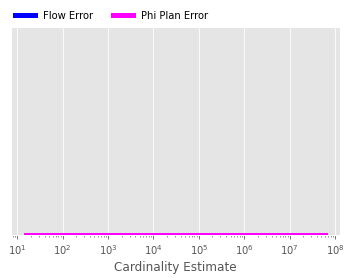

In [19]:
# print("num subsets: ", len(data))
for subset in data:
    print(subset)
    plot_subset_fig(data, subset, legend=True, plot_plan_err=False)
    plot_subset_fig(data, subset, legend=True, plot_plan_err=True)

# SUBSETS_TO_PLOT = ["[('ci', 'rt')]", "[('ci', 'n', 'rt')]", "[('ci', 'n', 'rt', 't')]", "[('ci', 'n', 't')]", "[('ci', 'kt', 'rt', 't')]"]
# for i, subset in enumerate(SUBSETS_TO_PLOT):
#     plot_subset_fig(data, subset, legend=True)
#     if i == 0:
#         plot_subset_fig(data, subset, legend=True)
#     else:
#         plot_subset_fig(data, subset, legend=False)

print(data.keys())

In [59]:
def plot_subset_fig(data, subsets):

    xs,qerrs,flow_errs,plan_errs,pg_errs,_,_,_,_,_ = data[subsets]
    flow_errs = list(zip(*flow_errs))[1]
    flow_errs = np.round(flow_errs)

    subsets = subsets.replace("[","")
    subsets = subsets.replace("]","")
    
    plt.figure(figsize=(5,4))
    plt.style.use('ggplot')
    ax = plt.gca()
    
    HUES = {}
    HUES["Flow Error"] = "blue"
    label = "Flow Error"
   
    sns.lineplot(xs, flow_errs, label=label, ax=ax, linewidth=5.0, zorder=5, 
                 color=HUES[label])
 
    plt.xscale("log")
    plt.ylabel("Errors")
    ax.set_xlabel("Cardinality Estimate of "+subsets)
    
    fn = FN_TMP2.format(SUBSET=subset)
    plt.savefig(fn)

num subsets:  17


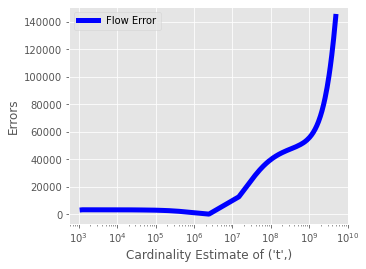

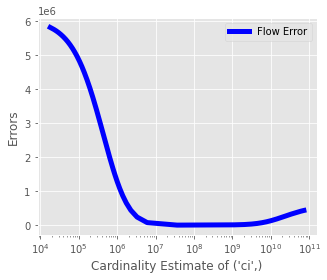

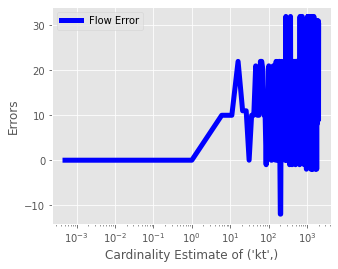

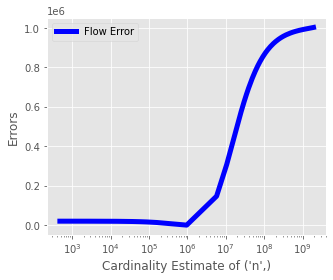

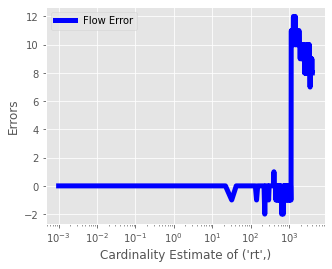

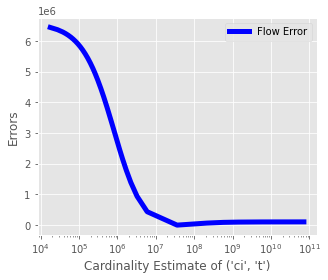

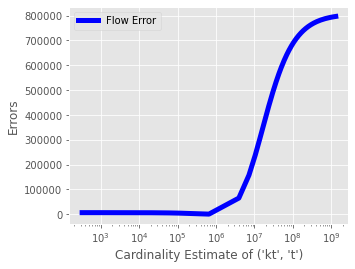

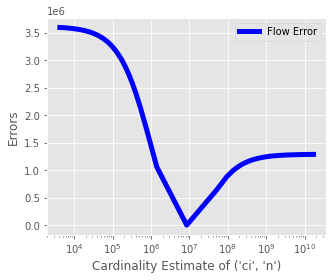

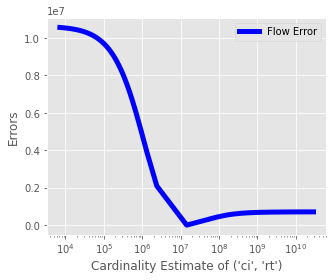

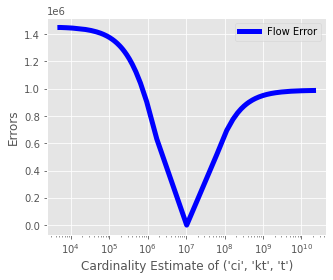

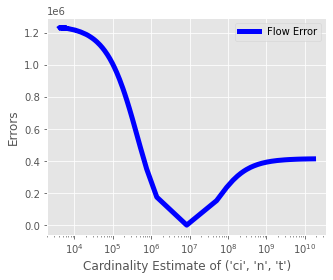

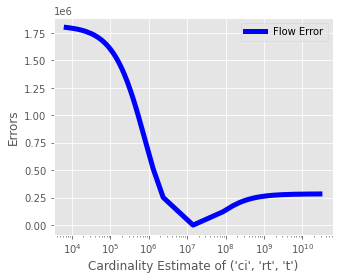

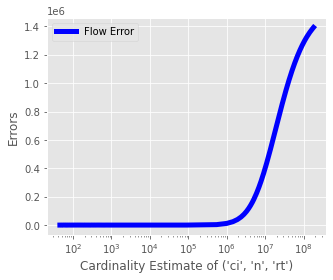

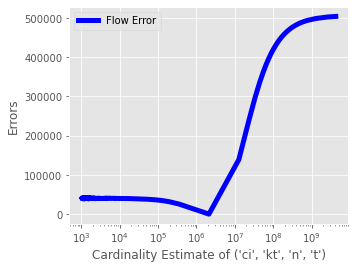

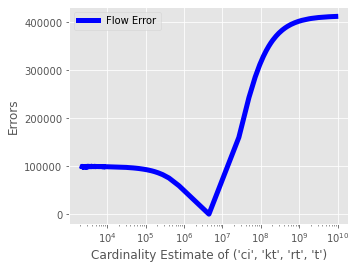

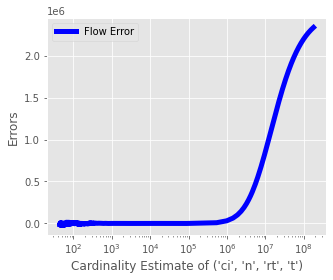

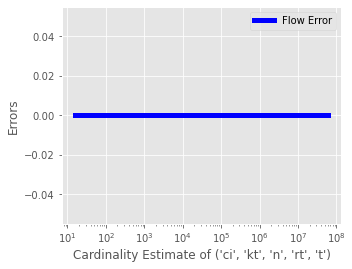

In [60]:
print("num subsets: ", len(data))
for subset in data:
    plot_subset_fig(data, subset)